In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [93]:
def remove_heavilyCorr_normalize_df(df):
    scaler = StandardScaler()
    df.columns = df.columns.str.strip()
    df=df.drop(columns=['Net Income Flag','Liability-Assets Flag'],axis=1) # Drop the column with only one value
    df_X = df.drop(columns=['Bankrupt?'])
    df_X = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns)
    df_y = df['Bankrupt?']
    cols_remove=['ROA(A) before interest and % after tax',
 'Net Value Per Share (A)',
 'Operating Profit Per Share (Yuan ¥)',
 'ROA(B) before interest and depreciation after tax',
 'Per Share Net profit before tax (Yuan ¥)',
 'Operating profit/Paid-in capital',
 'Net Value Per Share (C)',
 'Persistent EPS in the Last Four Seasons',
 'ROA(C) before interest and depreciation before interest',
 'Net Value Per Share (B)',
 'Net profit before tax/Paid-in capital',
 'Retained Earnings to Total Assets',
 'Operating Gross Margin',
 'Realized Sales Gross Margin',
 'Continuous interest rate (after tax)',
 'After-tax net Interest Rate',
 'Pre-tax net Interest Rate',
 'Non-industry income and expenditure/revenue',
 'Working capitcal Turnover Rate',
 'Cash Reinvestment %',
 'Cash Flow Per Share',
 'Operating Funds to Liability',
 'CFO to Assets',
 'After-tax Net Profit Growth Rate',
 'Current Liability to Assets',
 'Debt ratio %',
 'Inventory and accounts receivable/Net value',
 'Current Liabilities/Equity',
 'Borrowing dependency',
 'Current Liability to Equity',
 "Net Income to Stockholder's Equity",
 'Equity to Long-term Liability',
 'Contingent liabilities/Net worth',
 'Net Worth Turnover Rate (times)',
 'Working Capital to Total Assets',
 'Quick Assets/Total Assets',
 'Current Liabilities/Liability',
 'Cash Flow to Liability']
    df_X=df_X.drop(columns=cols_remove,axis=1)
    return df_X,df_y

df = pd.read_csv('data.csv',sep=',')
df_X,df_y=remove_heavilyCorr_normalize_df(df)

In [101]:
corr_seuil=0.6
for x in df_X.columns:
    for y in df_X.columns:
        if x!=y:
            if abs(df_X[x].corr(df_X[y]))>corr_seuil:
                print(x,y,df_X[x].corr(df_X[y]))

Operating Profit Growth Rate Regular Net Profit Growth Rate 0.6367928199888557
Regular Net Profit Growth Rate Operating Profit Growth Rate 0.6367928199888557
Net worth/Assets Equity to Liability 0.6258790580947228
Working Capital/Equity Liability to Equity -0.6504735718213024
Liability to Equity Working Capital/Equity -0.6504735718213024
Equity to Liability Net worth/Assets 0.6258790580947227


<Axes: xlabel='Operating Profit Growth Rate', ylabel='Regular Net Profit Growth Rate'>

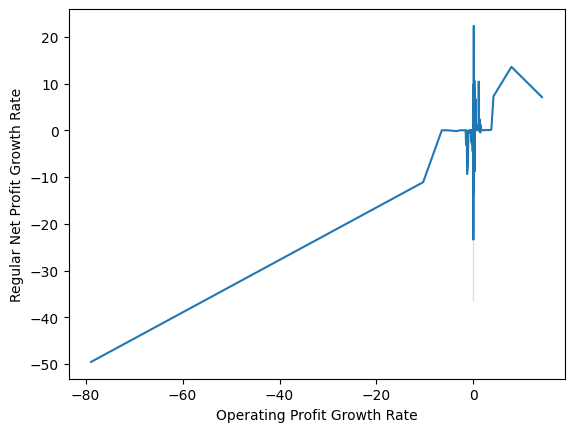

In [103]:
sns.lineplot(x=df_X['Operating Profit Growth Rate'],y=df_X['Regular Net Profit Growth Rate'] )


C:\Users\Ad\AppData\Local\Temp\ipykernel_3952\3120837875.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(1, n_comp+1), y=cumulative_variance_scaled, palette="viridis")


[]

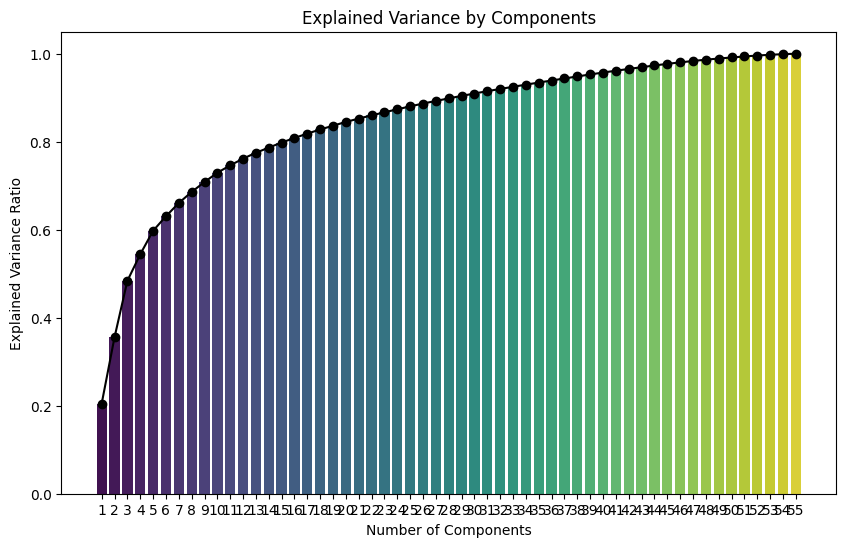

In [41]:
# ACP 

from sklearn.decomposition import PCA

df = pd.read_csv('data.csv',sep=',')
df_X,df_y=remove_heavilyCorr_normalize_df(df)

weight_bankrupt=0.5/220
weight_Non_bankrupt=0.5/6599

weights=np.where(df_y==1,weight_bankrupt,weight_Non_bankrupt)
scaled_X = df_X.multiply(np.sqrt(weights), axis=0)
n_comp=55
pca = PCA(n_components=n_comp)
pca_data=pca.fit_transform(scaled_X)

cumulative_variance_scaled = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, n_comp+1), y=cumulative_variance_scaled, palette="viridis")
plt.plot(np.arange(0, n_comp), cumulative_variance_scaled, marker='o', linestyle='-', color='black')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.plot()




In [67]:
cumulative_variance_scaled[15]

0.8085085415477331

In [70]:
pca_11col=pca_data[:,0:12]

In [71]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(pca_11col, df_y)
print(clf.score(pca_11col, df_y))

0.9824021117465904


In [74]:
clf.predict(pca_11col)
# matrice de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(df_y, clf.predict(pca_11col))
# expliquer la matrice de confusion
from sklearn.metrics import classification_report

print(classification_report(df_y, clf.predict(pca_11col)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6599
           1       0.68      0.85      0.76       220

    accuracy                           0.98      6819
   macro avg       0.84      0.92      0.87      6819
weighted avg       0.98      0.98      0.98      6819



In [72]:
df_y.value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [75]:
# tester la normalité des prédicteurs

from scipy.stats import shapiro

shapiro_test = shapiro(pca_11col[:,0:1])
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk Test: Statistic=0.059254817028263185, p-value=7.634117657035548e-103


C:\Users\Ad\AppData\Local\Temp\ipykernel_3952\2828493856.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6819.
  shapiro_test = shapiro(pca_11col[:,0:1])


In [77]:
from scipy.stats import kstest

def test_normality_ks(data):
    for i in range(data.shape[1]):
        kstest_test = kstest(data[:, i], 'norm')
        print(f"Column {i+1}: Kolmogorov-Smirnov Test Statistic={kstest_test.statistic}, p-value={kstest_test.pvalue}")

# Test normality of each column in pca_11col
test_normality_ks(pca_11col)

Column 1: Kolmogorov-Smirnov Test Statistic=0.4906398203011324, p-value=0.0
Column 2: Kolmogorov-Smirnov Test Statistic=0.4959743039342949, p-value=0.0
Column 3: Kolmogorov-Smirnov Test Statistic=0.4944084119665563, p-value=0.0
Column 4: Kolmogorov-Smirnov Test Statistic=0.4824673630840942, p-value=0.0
Column 5: Kolmogorov-Smirnov Test Statistic=0.49232261351876305, p-value=0.0
Column 6: Kolmogorov-Smirnov Test Statistic=0.4764164161132477, p-value=0.0
Column 7: Kolmogorov-Smirnov Test Statistic=0.4908409827232115, p-value=0.0
Column 8: Kolmogorov-Smirnov Test Statistic=0.48093789528016573, p-value=0.0
Column 9: Kolmogorov-Smirnov Test Statistic=0.480538461851207, p-value=0.0
Column 10: Kolmogorov-Smirnov Test Statistic=0.47778145985296294, p-value=0.0
Column 11: Kolmogorov-Smirnov Test Statistic=0.4785823467108642, p-value=0.0
Column 12: Kolmogorov-Smirnov Test Statistic=0.4756440118646133, p-value=0.0


array([[ 0.10262643],
       [ 0.03331563],
       [ 0.02131774],
       ...,
       [-0.00695611],
       [-0.00610569],
       [-0.00895331]])

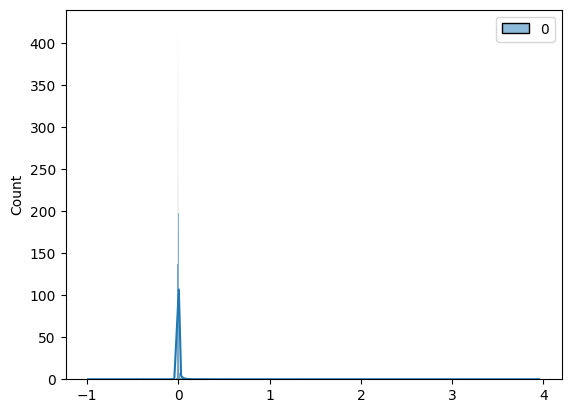

In [81]:
sns.histplot(pca_11col[:,0:1], kde=True)
pca_11col[:,:1]